### TP 4 :

###### Group : Alexandre BOISTARD, William ROCHE, Ethan TRENTIN

In [1]:
!pip install powerlaw
!pip install Hawkes

In [2]:
import numpy
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import powerlaw
import statsmodels
from statsmodels import api
from tqdm import tqdm
import Hawkes as hwk

Question 1 : **Brownian motions with Poisson sampling.** Take your results from Lab 2 Question 2 and add the Hayashi-Yoshida estimator to the plot.

We first take the results from Lab 2 Question 2 that was made to simulate Brownian motions with Poisson sampling. So, let's copy the code and improve it.

In [3]:
def simulate_trade_times(mu, T):
    times = []
    t = 0
    while t < T:
        t += numpy.random.exponential(1/mu)
        if t < T:
            times.append(t)
    return numpy.array(times)

In [4]:
def get_trade_prices(time_grid, prices, trade_times):
    # np.searchsorted returns the index of the first element in prices that is greater than or equal to trade_times
    idx = numpy.searchsorted(time_grid, trade_times, side='right')-1
    return prices[idx]

In [5]:
def synchronize_to_grid(trade_times, trade_prices, sampling_times):
    sync_prices = []
    pos = 0
    for gt in sampling_times:
        # We move the position pos until the trade time is greater than the grid time
        while pos < len(trade_times) and trade_times[pos] <= gt:
            pos += 1
        if pos == 0:
            # If no trade has occured yet, we use the set price to NaN or 0.
            sync_prices.append(numpy.nan)
        else:
            sync_prices.append(trade_prices[pos-1])
    return numpy.array(sync_prices)

In [6]:
def compute_covariance_estimator(prices1, prices2):
    # We compute the quadratic variation of the processes.
    returns1 = numpy.diff(prices1)
    returns2 = numpy.diff(prices2)
    return numpy.nansum(returns1 * returns2)

Now, we are going to create a function to get the Hayashi-Yoshida estimator and later add it to the plot of the simulation.

In [6]:
def hayashi_yoshida_estimator(times1, times2, prices1, prices2):
    if len(times1) < 2 or len(times2) < 2:
        return 0.0
    increments1 = numpy.diff(prices1)
    increments2 = numpy.diff(prices2)
    i,j = 1,1
    hayashi_yoshida = 0.0
    while i < len(increments1) and j < len(increments2):
        start = max(times1[i-1], times2[j-1])
        end = min(times1[i], times2[j])
        if start < end:
            hayashi_yoshida += increments1[i-1] * increments2[j-1]
        if times1[i] < times2[j]:
            i += 1
        else:
            j += 1
    return hayashi_yoshida

In [7]:
def simulation(T, n_paths, tau_values, mu_1, mu_2, sigma_1, sigma_2, rho):
    dt = 0.0005
    time_grid = numpy.arange(0, T+dt, dt)
    sampling_grids = {}
    for tau in tau_values:
        sampling_grids[tau] = numpy.arange(0, T + tau, tau)
    # We precompute the Brownian increments on the time grid
    n_steps = len(time_grid)

    Z_1 = numpy.random.normal(0,1,(n_paths, n_steps))
    Z_2 = numpy.random.normal(0,1,(n_paths, n_steps))

    # We compute the correlated increments with the Cholesky factorization
    dW_1 = numpy.sqrt(dt) * Z_1
    dW_2 = numpy.sqrt(dt) * (rho * Z_1 + numpy.sqrt(1-rho**2) * Z_2)

    W_1 = numpy.cumsum(dW_1, axis=1)
    W_2 = numpy.cumsum(dW_2, axis=1)

    p_1_full = sigma_1 * W_1
    p_2_full = sigma_2 * W_2
    cov_estimates = {tau: [] for tau in tau_values}
    Hayashi_Yoshida_estimates = []
    for i in tqdm(range(n_paths)):

        trade_times_1 = simulate_trade_times(mu_1, T)
        trade_times_2 = simulate_trade_times(mu_2, T)

        trade_prices_1 = get_trade_prices(time_grid, p_1_full[i,:], trade_times_1)
        trade_prices_2 = get_trade_prices(time_grid, p_2_full[i,:], trade_times_2)

        for tau in tau_values:

            sampling_times = sampling_grids[tau]

            sync_prices_1 = synchronize_to_grid(trade_times_1, trade_prices_1, sampling_times)
            sync_prices_2 = synchronize_to_grid(trade_times_2, trade_prices_2, sampling_times)

            cov_est = compute_covariance_estimator(sync_prices_1, sync_prices_2)
            cov_estimates[tau].append(cov_est)

        Hayashi_Yoshida_estimates.append(hayashi_yoshida_estimator(trade_times_1, trade_times_2, trade_prices_1, trade_prices_2))

    theoretical_cov = rho * sigma_1 * sigma_2 * T
    mean_cov = []
    std_cov = []
    for tau in tau_values:
        mean_cov.append(numpy.nanmean(cov_estimates[tau]))
        std_cov.append(numpy.nanstd(cov_estimates[tau]))

    mean_cov = numpy.array(mean_cov)
    std_cov = numpy.array(std_cov)

    mean_HY = numpy.mean(Hayashi_Yoshida_estimates)
    std_HY = numpy.std(Hayashi_Yoshida_estimates)
    plt.figure(figsize=(8, 6))
    plt.plot(tau_values, mean_cov, label='Mean covariance estimate', marker='o')
    plt.fill_between(tau_values, mean_cov - 2*std_cov, mean_cov + 2*std_cov, alpha=0.3, label='Theoretical ±2 std (grid-based)')
    plt.axhline(mean_HY, color='red', linestyle='-', linewidth=2, label=f'Mean Hayashi-Yoshida estimate {mean_HY:.2f}')
    plt.axhline(theoretical_cov, color='black', linestyle='dashed', linewidth=2, label=f'Theoretical covariance {theoretical_cov:.2f}')
    plt.fill_between(tau_values, mean_HY - 2*std_HY, mean_HY + 2*std_HY, alpha=0.3, label='Hayashi-Yoshida ±2 std')
    plt.xscale('log')
    plt.xlabel("Sampling period ($\tau$)")
    plt.ylabel("Covariance estimate")
    plt.title(f"Mean covariance estimates over {n_paths} paths vs. sampling period ($\\tau$)")
    plt.legend()
    plt.show()

In [8]:
# Let's define the parameters of the model
T = 5 # Total time
n_paths = 2000 # Number of paths
mu_1 = 100 # Intensity of the first Poisson process
mu_2 = 120 # Intensity of the second Poisson process
sigma_1 = 0.5
sigma_2 = 0.75
rho = 0.75 # Correlation between the 2 Brownian motions
tau_values = numpy.logspace(-3, 0, 20) # Sampling periods

100%|██████████| 2000/2000 [00:58<00:00, 34.40it/s]


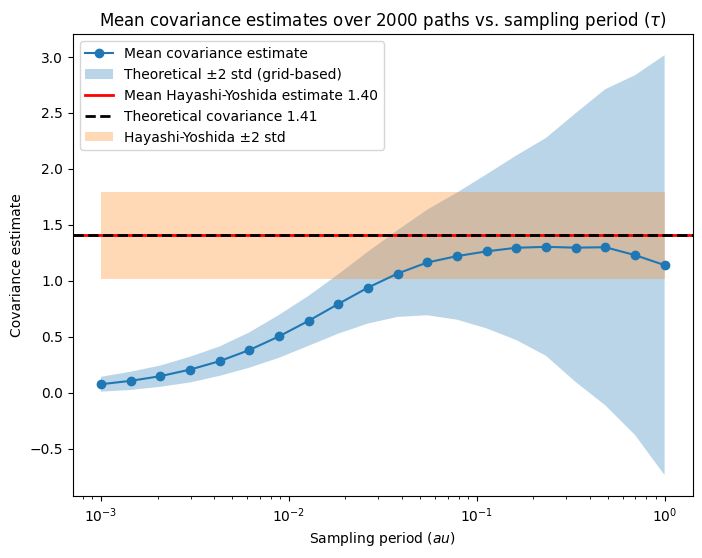

In [37]:
simulation(T, n_paths, tau_values, mu_1, mu_2, sigma_1, sigma_2, rho)

Comments : This plot illustrates the mean covariance estimates over 2000 simulated paths as a function of the sampling period, providing a comprehensive view of how the standard and the Hayashi-Yoshida estimators perform relative to the theoretical covariance. The x-axis represents the sampling period on a logarithmic scale. The blue line with markers depicts the mean covariance estimate, which starts near zero for very small sampling periods and gradually increases, reaching its peak value slightly below the theoretical covariance, indicated by the black dashed line. The light blue shaded area around the blue line represents the theoretical ±2 standard deviations, which highlights the variability of the standard covariance estimates (synchronozing the two processes on a similar grid). In contrast, the red line represents the mean Hayashi-Yoshida estimate, which remains stable and close to the theoretical covariance across all sampling periods, as it doesn't need a sampling period to be computed but only the trade times, even though the two processes are asynchroneous. This shows the robustness of this estimation compared to the standard covariance estimation. The orange shaded region around the red line indicates the ±2 standard deviations for the Hayashi-Yoshida estimator, showing a tighter confidence interval compared to the grid-based estimator. The Hayashi-Yoshida estimator is not only more accurate but also more precise, as shown by its lower variability.

Therefore, the Hayashi-Yoshida estimator seems to be a better choice to estimate covariance of two simulated processes. We will study later how it behaves on real trade prices.

Now, we are going to study the statistical properties of the Hayashi-Yoshida estimator we just computed.

First, we are going to see if the estimator is consistent. To do so, we need to compute the estimator for different number of simulations and see how it behaves when this number of simulations increases.

In [9]:
def simulate_hy_estimator(function, n_paths_array, T, mu_1, mu_2, sigma_1, sigma_2, rho):
    dt = 0.0005
    time_grid = numpy.arange(0, T + dt, dt)
    n_steps = len(time_grid)

    hy_estimates_evolution = []

    for n_paths in tqdm(n_paths_array):
        Z_1 = numpy.random.normal(0, 1, (n_paths, n_steps))
        Z_2 = numpy.random.normal(0, 1, (n_paths, n_steps))
        dW_1 = numpy.sqrt(dt) * Z_1
        dW_2 = numpy.sqrt(dt) * (rho * Z_1 + numpy.sqrt(1 - rho**2) * Z_2)

        W_1 = numpy.cumsum(dW_1, axis=1)
        W_2 = numpy.cumsum(dW_2, axis=1)

        p_1_full = sigma_1 * W_1
        p_2_full = sigma_2 * W_2
        hy_estimates = []
        for i in range(n_paths):

            trade_times_1 = simulate_trade_times(mu_1, T)
            trade_times_2 = simulate_trade_times(mu_2, T)

            trade_prices_1 = get_trade_prices(time_grid, p_1_full[i,:], trade_times_1)
            trade_prices_2 = get_trade_prices(time_grid, p_2_full[i,:], trade_times_2)

            hy_estimate = function(trade_times_1, trade_times_2, trade_prices_1, trade_prices_2)
            hy_estimates.append(hy_estimate)

        mean_hy_estimate = numpy.mean(hy_estimates)
        hy_estimates_evolution.append(mean_hy_estimate)
    return hy_estimates_evolution

In [17]:
def plot_consistency(estimates, n_paths_array, T, mu_1, mu_2, sigma_1, sigma_2, rho, name):
    theoretical_cov = rho * sigma_1 * sigma_2 * T
    theoretical_corr = rho
    plt.figure(figsize=(12, 6))
    plt.plot(n_paths_array, estimates, label='Mean Hayashi-Yoshida Estimate', marker='o')
    if name == 'covariance':
        plt.axhline(theoretical_cov, color='red', linestyle='--', label=f'True {name}')
    elif name == 'correlation':
        plt.axhline(theoretical_corr, color='red', linestyle='--', label=f'True {name}')
    plt.xlabel('Number of Simulation Paths')
    plt.xscale('log')
    plt.ylabel(f'Estimated {name}')
    plt.title('Evolution of Hayashi-Yoshida Estimator with Increasing Simulation Paths')
    plt.legend()
    plt.show()

100%|██████████| 20/20 [03:29<00:00, 10.46s/it]


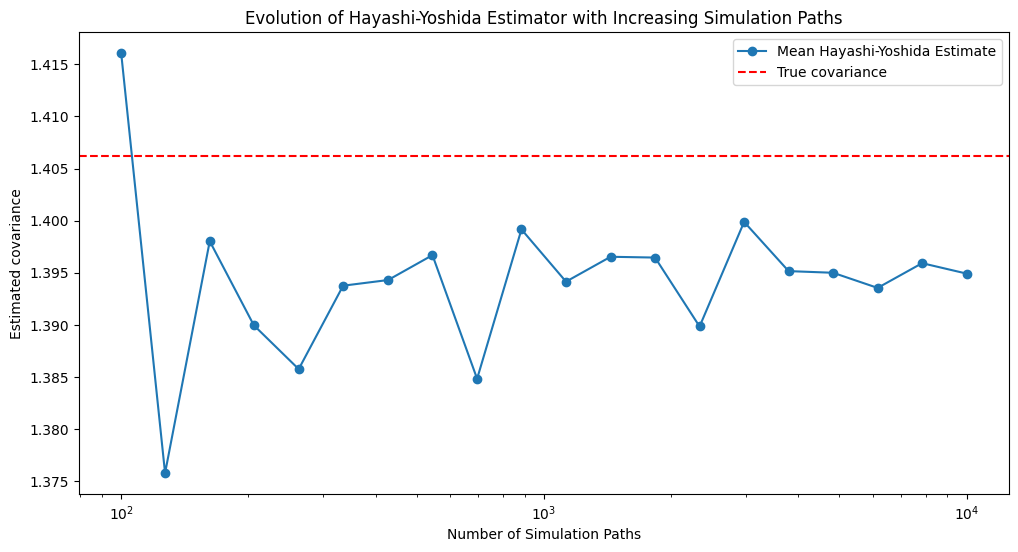

In [13]:
n_paths_array = numpy.logspace(2, 4, 20, dtype=int)
hy_covariance = simulate_hy_estimator(hayashi_yoshida_estimator, n_paths_array, T, mu_1, mu_2, sigma_1, sigma_2, rho)
plot_consistency(hy_covariance, n_paths_array, T, mu_1, mu_2, sigma_1, sigma_2, rho, 'covariance')

Comments : This plot show the consistency of the Hayashi-Yoshida estimator. Initially, the estimates exhibit significant variability reflecting the stochastic nature of the simulations. As the number of paths increases, the estimates tend to stabilize even though a slight biais can be seen when compared to the true covariance value. This suggests that while the estimator converges, a higher number of paths is necessary to achieve consistent and accurate results.

Let's now study the asymptotic normality of the Hayashi-Yoshida estimator.

In [ ]:
n_paths_array = numpy.logspace(4, 6, 10, dtype=int)
simulate_hy_estimator(hayashi_yoshida_estimator, n_paths_array, T, mu_1, mu_2, sigma_1, sigma_2, rho)

 20%|██        | 2/10 [01:57<08:13, 61.66s/it]

In [12]:
def simulate_hy_estimator_normality(T, n_paths, mu_1, mu_2, sigma_1, sigma_2, rho):
    dt = 0.0005
    time_grid = numpy.arange(0, T + dt, dt)
    n_steps = len(time_grid)

    hy_estimates = []

    Z_1 = numpy.random.normal(0, 1, (n_paths, n_steps))
    Z_2 = numpy.random.normal(0, 1, (n_paths, n_steps))
    dW_1 = numpy.sqrt(dt) * Z_1
    dW_2 = numpy.sqrt(dt) * (rho * Z_1 + numpy.sqrt(1 - rho**2) * Z_2)

    W_1 = numpy.cumsum(dW_1, axis=1)
    W_2 = numpy.cumsum(dW_2, axis=1)

    p_1_full = sigma_1 * W_1
    p_2_full = sigma_2 * W_2
    for i in range(n_paths):

        trade_times_1 = simulate_trade_times(mu_1, T)
        trade_times_2 = simulate_trade_times(mu_2, T)

        trade_prices_1 = get_trade_prices(time_grid, p_1_full[i,:], trade_times_1)
        trade_prices_2 = get_trade_prices(time_grid, p_2_full[i,:], trade_times_2)

        hy_estimate = hayashi_yoshida_estimator(trade_times_1, trade_times_2, trade_prices_1, trade_prices_2)
        hy_estimates.append(hy_estimate)
    hy_mean = numpy.nanmean(hy_estimates)
    hy_std = numpy.nanstd(hy_estimates)

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    scipy.stats.probplot(hy_estimates, dist="norm", plot=ax[0])
    ax[0].set_title('Q-Q Plot for Asymptotic Normality Check of Hayashi-Yoshida estimator')
    ax[1].hist(hy_estimates, bins=30, density=True, alpha=0.6, color='b', label='HY Estimates Histogram')
    mu, std = scipy.stats.norm.fit(hy_estimates)
    xmin, xmax = ax[1].get_xlim()
    x = numpy.linspace(xmin, xmax, 100)
    p = scipy.stats.norm.pdf(x, mu, std)
    ax[1].plot(x, p, 'r', linewidth=2, label='Normal Distribution')
    ax[1].set_title('Histogram with Normal Distribution Overlay')
    ax[1].set_xlabel('Estimated Values')
    ax[1].set_ylabel('Density')
    plt.legend()
    plt.show()

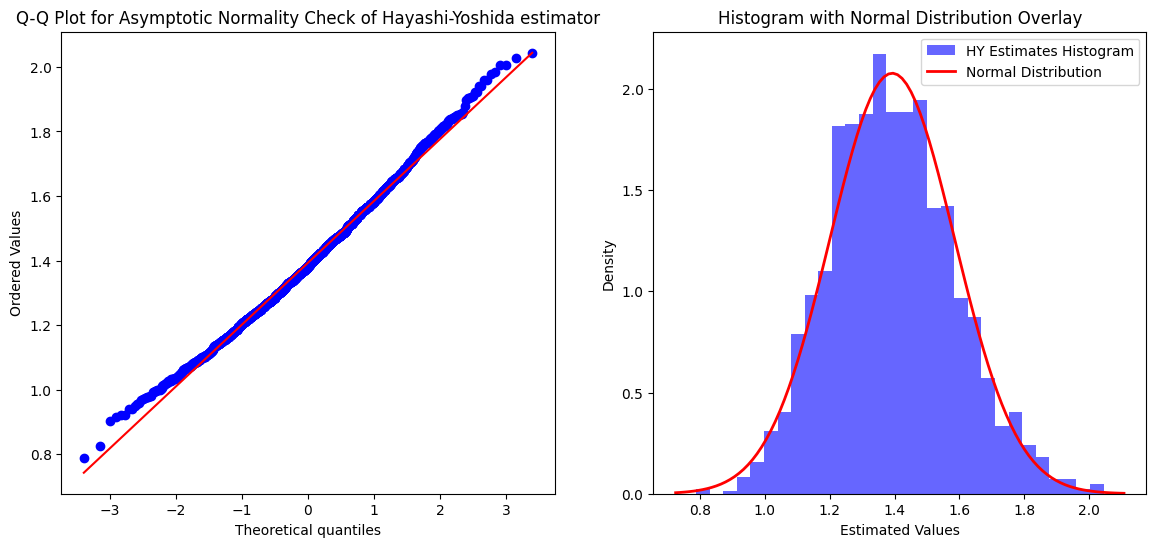

In [55]:
n_paths = 2000
simulate_hy_estimator_normality(T, n_paths, mu_1, mu_2, sigma_1, sigma_2, rho)

Comments : We displayed two plots : one QQ-plot that compares the quantiles of the empirical distribution of Hayashi-Yoshida estimator for a certain number of simulations (n_paths here) to the quantiles of a normal distribution, and a histogram of the values of the estimator, with a normal distribution overlay. Both plots argue in favor of the hypothesis that the Hayashi-Yoshida estimator is asymptotically normal. But, to be sure of this, we decided to implement some statistical tests after the plots. We will use Kolmogorov-Smirnov test and Anderson-Darling test in the function below.

In [13]:
def statistical_tests(T, n_batches, n_paths, mu_1, mu_2, sigma_1, sigma_2, rho):
    dt = 0.0005
    time_grid = numpy.arange(0, T + dt, dt)
    n_steps = len(time_grid)

    ks_rejections = 0
    ad_rejections = 0

    for _ in range(n_batches):
        hy_estimates = []

        Z_1 = numpy.random.normal(0, 1, (n_paths, n_steps))
        Z_2 = numpy.random.normal(0, 1, (n_paths, n_steps))
        dW_1 = numpy.sqrt(dt) * Z_1
        dW_2 = numpy.sqrt(dt) * (rho * Z_1 + numpy.sqrt(1 - rho**2) * Z_2)

        W_1 = numpy.cumsum(dW_1, axis=1)
        W_2 = numpy.cumsum(dW_2, axis=1)

        p_1_full = sigma_1 * W_1
        p_2_full = sigma_2 * W_2

        for i in range(n_paths):
            trade_times_1 = simulate_trade_times(mu_1, T)
            trade_times_2 = simulate_trade_times(mu_2, T)

            trade_prices_1 = get_trade_prices(time_grid, p_1_full[i, :], trade_times_1)
            trade_prices_2 = get_trade_prices(time_grid, p_2_full[i, :], trade_times_2)

            hy_estimate = hayashi_yoshida_estimator(trade_times_1, trade_times_2, trade_prices_1, trade_prices_2)
            hy_estimates.append(hy_estimate)

        hy_mean = numpy.nanmean(hy_estimates)
        hy_std = numpy.nanstd(hy_estimates)

        # Kolmogorov-Smirnov Test
        ks_stat, ks_pval = scipy.stats.kstest(hy_estimates, 'norm', args=(hy_mean, hy_std))
        if ks_pval < 0.05:
            ks_rejections += 1

        # Anderson-Darling Test
        anderson_stat = scipy.stats.anderson(hy_estimates, dist='norm')
        if anderson_stat.statistic > anderson_stat.critical_values[2]:  # Typically we will use the 5% significance level
            ad_rejections += 1

    total_tests = n_batches
    ks_acceptance = total_tests - ks_rejections
    ad_acceptance = total_tests - ad_rejections

    print("### Summary of Statistical Tests ###")
    print(f"Kolmogorov-Smirnov Test: {ks_rejections} rejections, {ks_acceptance} fail to reject H0 out of {total_tests} tests.")
    print(f"Anderson-Darling Test: {ad_rejections} rejections, {ad_acceptance} fail to reject H0 out of {total_tests} tests.")

In [57]:
statistical_tests(T, 100, n_paths, mu_1, mu_2, sigma_1, sigma_2, rho)

### Summary of Statistical Tests ###
Kolmogorov-Smirnov Test: 21 rejections, 79 fail to reject H0 out of 100 tests.
Anderson-Darling Test: 97 rejections, 3 fail to reject H0 out of 100 tests.


Comments : We decided to perform 100 tests of Kolmogorov-Smirnov and of Anderson-Darling and check for each if we could reject or not the H0 hypothesis that the distribution is normal. For the first test, in most cases, we failed to reject the normal hypothesis, meaning we can't say for sure that the distribution is not gaussian. However, the Anderson-Darling test, more sensitive to the deviations in the tais, rejects most of the time the normal hypothesis. It makes sense as we can see that the QQ-plot displays deviated tails (a beginning of fat tails). Therefore, according to this test, it is hard to conclude that the estimator is asymptotically gaussian. Maybe increasing the number of simulations (n_paths) could help reach this asymptotically property but would require much more time to compute.           

Finally, as $\rho$, $\sigma_1$ and $\sigma_2$ are constant, we can test the consistency of the correlation derived from the Hayashi-Yoshida estimator of the covariance.

In [14]:
def hayashi_yoshida_correlation(times1, times2, prices1, prices2):
    hy_estimator = hayashi_yoshida_estimator(times1, times2, prices1, prices2)
    var1 = hayashi_yoshida_estimator(times1, times1, prices1, prices1)
    var2 = hayashi_yoshida_estimator(times2, times2, prices2, prices2)
    return hy_estimator / numpy.sqrt(var1 * var2)

100%|██████████| 20/20 [06:01<00:00, 18.07s/it]


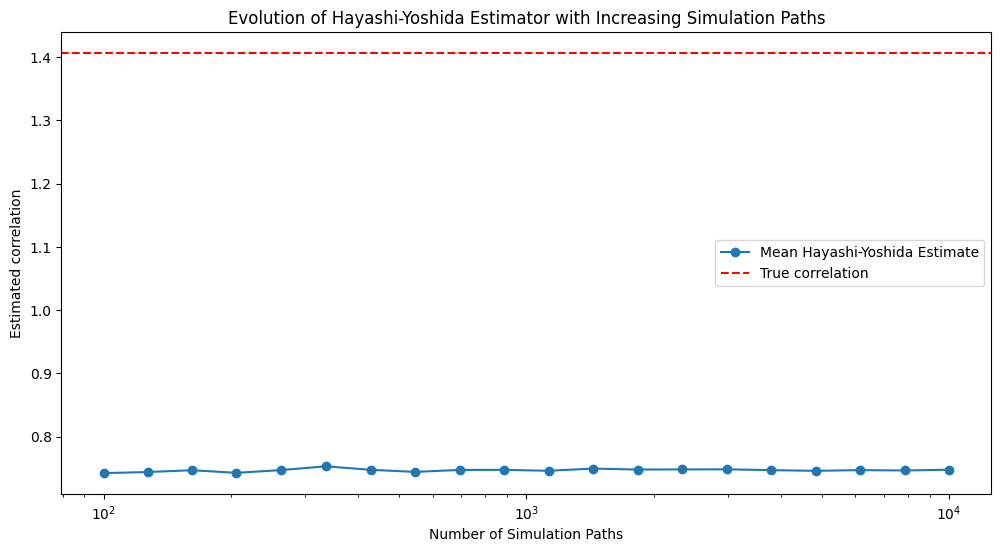

In [16]:
n_paths_array = numpy.logspace(2, 4, 20, dtype=int)
hy_correlation = simulate_hy_estimator(hayashi_yoshida_correlation, n_paths_array, T, mu_1, mu_2, sigma_1, sigma_2, rho)
plot_consistency(hy_correlation, n_paths_array, T, mu_1, mu_2, sigma_1, sigma_2, rho, 'correlation')

Question 2 : **Signature plots and Epps effect.** On our dataset, we are going to estimate the integrated realized
variances for each stock and the correlation between the two stocks using the standard estimators and the Hayashi-Yoshida estimators. Comment.

In [ ]:
data_path_SG = "Data/SG/"
file_list_SG = [
    "SG_20170117.csv.gz",
    "SG_20170118.csv.gz",
    "SG_20170119.csv.gz",
    "SG_20170120.csv.gz",
    "SG_20170123.csv.gz",
    "SG_20170124.csv.gz",
    "SG_20170125.csv.gz",
    "SG_20170126.csv.gz",
    "SG_20170127.csv.gz",
    "SG_20170130.csv.gz",
    "SG_20170131.csv.gz",
    "SG_20170201.csv.gz",
]
df_list_SG = []
for file in file_list_SG:
    df_SG = pd.read_csv(file, compression='gzip')
    df_SG.drop(df_SG.columns[0], axis=1, inplace=True)
    df_SG['ets'] = pd.to_datetime(df_SG['ets'], format="%Y%m%d:%H:%M:%S.%f")
    df_list_SG.append(df_SG)

filename_df_SG = pd.concat(df_list_SG, ignore_index=True)
filename_df_SG['ets'] = pd.to_datetime(filename_df_SG['ets'])
filename_df_SG.head()

In [ ]:
data_path_BNPP = "Data/BNPP/"
file_list_BNPP = [
    "BNPP_20170117.csv.gz",
    "BNPP_20170118.csv.gz",
    "BNPP_20170119.csv.gz",
    "BNPP_20170120.csv.gz",
    "BNPP_20170123.csv.gz",
    "BNPP_20170124.csv.gz",
    "BNPP_20170125.csv.gz",
    "BNPP_20170126.csv.gz",
    "BNPP_20170127.csv.gz",
    "BNPP_20170130.csv.gz",
    "BNPP_20170131.csv.gz",
    "BNPP_20170201.csv.gz",
]
df_list_BNPP = []
for file in file_list_BNPP:
    df_BNPP = pd.read_csv(file, compression='gzip')
    df_BNPP.drop(df_BNPP.columns[0], axis=1, inplace=True)
    df_BNPP['ets'] = pd.to_datetime(df_BNPP['ets'], format="%Y%m%d:%H:%M:%S.%f")
    df_list_BNPP.append(df_BNPP)

filename_df_BNPP = pd.concat(df_list_BNPP, ignore_index=True)
filename_df_BNPP['ets'] = pd.to_datetime(filename_df_BNPP['ets'])
filename_df_BNPP.head()

In [ ]:
filtered_df_SG = filename_df_SG[filename_df_SG['etype']=='T']
filtered_df_BNPP = filename_df_BNPP[filename_df_BNPP['etype']=='T']

In [ ]:
def realized_variance_time_resample(df, freq_in_seconds):
    """
    df : DataFrame contenant au moins les colonnes ['ets', 'eprice'].
    freq_in_seconds : entier ou float en secondes
    """
    df = df.sort_values('ets').copy()
    df.set_index('ets', inplace=True)

    rule = f'{freq_in_seconds}s'

    price_resampled = df['eprice'].resample(rule).last().ffill()

    log_price = numpy.log(price_resampled)
    log_returns = log_price.diff().dropna()

    rv = (log_returns**2).sum()
    return rv

In [ ]:
def signature_plot(df, sampling_periods_in_seconds, stock_name):
    """
    df : DataFrame multi-jour contenant [ets, eprice].
    sampling_periods_in_seconds : liste/array de fréquences (en secondes)
    """
    df = df.copy()
    df['ets'] = pd.to_datetime(df['ets'])

    daily_rv_for_each_freq = []
    daily_rv_std_for_each_freq = []

    for sp in sampling_periods_in_seconds:
        daily_values = []
        for date, group in df.groupby(df['ets'].dt.date):
            if len(group) > 1:
                rv = realized_variance_time_resample(group, sp)*10000
                daily_values.append(rv)
        daily_rv_for_each_freq.append(numpy.mean(daily_values))
        daily_rv_std_for_each_freq.append(numpy.std(daily_values))

    plt.figure(figsize=(10,5))
    plt.plot(sampling_periods_in_seconds, [daily_var for daily_var in daily_rv_for_each_freq], marker='v', color='blue', label="Realized Variance")
    plt.fill_between(sampling_periods_in_seconds, [2*daily_var_std + daily_var for daily_var, daily_var_std in zip(daily_rv_for_each_freq, daily_rv_std_for_each_freq)], [daily_var - 2*daily_var_std for daily_var, daily_var_std in zip(daily_rv_for_each_freq, daily_rv_std_for_each_freq)], color='blue', alpha=0.3, label = "Realized Variance ±2 std")
    plt.xlabel("Sampling Period (s)")
    plt.ylabel("Realized Variance ($10^{-4}$)")
    plt.title(f"Signature Plot - {stock_name}")
    plt.show()

In [ ]:
sampling_periods = numpy.arange(1, 101, 1)
signature_plot(filtered_df_SG, sampling_periods, "SG")

In [ ]:
signature_plot(filtered_df_BNPP, sampling_periods, "BNPP")

In [ ]:
def compute_standard_correlation_for_day(df1, df2, sampling_period):
    """This function aligns the two dataframes on the same temporal references for one day (we will use it in an another function to use all days). It creates a common grid, synchronizes the prices, calculates the log-returns and finally the correlation.
    It takes 3 arguments :
    - df1 : the first stock Dataframe containing a column 'ets' and a column 'eprice'.
    - df2 : the second stock Dataframe.
    - sampling_period : the sampling period in seconds.
    """
    # The dataframe are supposed to be sorted in the temporal order but just to make sure we use sort_values.
    df1 = df1.sort_values('ets').copy()
    df2 = df2.sort_values('ets').copy()

    # Using .astyp('int64') converts the time into nanoseconds, hence the division by 10**9 to get seconds.
    df1['ets_sec'] = df1['ets'].astype('int64') // 10**9
    df2['ets_sec'] = df2['ets'].astype('int64') // 10**9

    t0 = min(df1['ets_sec'].iloc[0], df2['ets_sec'].iloc[0])
    df1['ets_aligned'] = df1['ets_sec'] - t0
    df2['ets_aligned'] = df2['ets_sec'] - t0

    times1 = df1['ets_aligned'].values
    times2 = df2['ets_aligned'].values
    # We use the eprice, which is the price of the trade (as we will use only the stocks that we actually traded).
    prices1 = df1['eprice'].values
    prices2 = df2['eprice'].values

    # We compute the time horizon as the minimum of the two time horizons for the stocks.
    T_common = min(times1[-1], times2[-1])
    sampling_times = numpy.arange(0, T_common + sampling_period, sampling_period)

    # We synchronize the prices thanks to the function created in the TP2 and used in the first question of this TP.
    sync_prices1 = synchronize_to_grid(times1, prices1, sampling_times)
    sync_prices2 = synchronize_to_grid(times2, prices2, sampling_times)

    # We compute the log prices of the synchronized prices.
    log_p1 = numpy.log(sync_prices1)
    log_p2 = numpy.log(sync_prices2)

    # To get the covariance estimation, we use the function created to have the standard covariance estimator on the lig prices as it will compute the difference inside the function to get the log returns.
    cov = compute_covariance_estimator(log_p1, log_p2)
    var1 = compute_covariance_estimator(log_p1, log_p1)
    var2 = compute_covariance_estimator(log_p2, log_p2)

    # Finally, we can compute the correlation by dividing the covariance by the standard deviations of both stocks.
    if var1 > 0 and var2 > 0:
        corr = cov / numpy.sqrt(var1 * var2)
    else:
        corr = numpy.nan
    return corr

In [ ]:
def compute_hy_correlation_for_day(df1, df2):
    """This function computes the Hayashi-Yoshida correlation for one day. It takes 2 arguments :
    - df1 : the first stock Dataframe containing a column 'ets' and a column 'eprice'.
    - df2 : the second stock Dataframe.
    No need for a sampling period here as it works directly for asynchroneous stocks.
    """
    df1 = df1.sort_values('ets').copy()
    df2 = df2.sort_values('ets').copy()

    df1.loc[:, 'ets_sec'] = df1['ets'].astype('int64') // 10**9
    df2.loc[:, 'ets_sec'] = df2['ets'].astype('int64') // 10**9
    times1 = df1['ets_sec'].values
    times2 = df2['ets_sec'].values
    prices1 = df1['eprice'].values
    prices2 = df2['eprice'].values
    log_prices1 = numpy.log(prices1)
    log_prices2 = numpy.log(prices2)
    # We use the previously implemented function (in question 1) to get the Hayashi-Yoshida covariance estimator.
    hy_cov = hayashi_yoshida_estimator(times1, times2, log_prices1, log_prices2)

    # We compute the variance with the same estimator.
    var1 = hayashi_yoshida_estimator(times1, times1, log_prices1, log_prices1)
    var2 = hayashi_yoshida_estimator(times2, times2, log_prices2, log_prices2)

    if var1 > 0 and var2 > 0:
        hy_corr = hy_cov / numpy.sqrt(var1 * var2)
    else:
        hy_corr = numpy.nan
    return hy_corr

In [ ]:
def plot_correlation_estimators(df_SG, df_BNPP, sampling_periods):
    """This function calculates the mean standard correlation for each sampling period considered, and also calculates the mean Hayashi-Yoshida correlation.
    It takes 3 arguments :
    - df_SG : the first stock Dataframe containing a column 'ets' and a column 'eprice'.
    - df_BNPP : the second stock Dataframe.
    - sampling_periods : an array of sampling periods (in seconds)."""

    # We get the common days (all days are supposed to be the same here but those lines can help make the work run for different datasets).
    dates = numpy.intersect1d(df_SG['ets'].dt.date.unique(), df_BNPP['ets'].dt.date.unique())

    standard_corrs_mean = []
    hy_corrs_list = []

    # For each date, we are going to compute the Hayashi-Yoshida estimator.
    for date in dates:
        df_SG_day = df_SG[df_SG['ets'].dt.date == date].copy()
        df_BNPP_day = df_BNPP[df_BNPP['ets'].dt.date == date].copy()
        if len(df_SG_day) < 2 or len(df_BNPP_day) < 2:
            continue
        hy_corr = compute_hy_correlation_for_day(df_SG_day, df_BNPP_day)
        hy_corrs_list.append(hy_corr)

    # We compute the mean of Hayashi-Yoshida correlation estimator for all days.
    hy_corr_mean = numpy.nanmean(hy_corrs_list)

    # For each sampling period, we will now calculate the mean of the standard correlation over the days.
    standard_corrs_by_tau = []
    for tau in sampling_periods:
        daily_corrs = []
        for date in dates:
            df_SG_day = df_SG[df_SG['ets'].dt.date == date].copy()
            df_BNPP_day = df_BNPP[df_BNPP['ets'].dt.date == date].copy()
            if len(df_SG_day) < 2 or len(df_BNPP_day) < 2:
                continue
            corr_std = compute_standard_correlation_for_day(df_SG_day, df_BNPP_day, tau)
            daily_corrs.append(corr_std)
        standard_corrs_by_tau.append(numpy.nanmean(daily_corrs))

    plt.figure(figsize=(10, 6))
    plt.plot(sampling_periods, standard_corrs_by_tau, marker='o', label='Mean standard correlation')
    plt.axhline(hy_corr_mean, color='red', linestyle='--', linewidth=2, label='Mean Hayashi–Yoshida correlation')
    plt.xlabel("Sampling period (s)")
    plt.ylabel("Estimated Correlation")
    plt.title("Comparison of the correlation estimators for SG and BNPP stocks")
    plt.legend()
    plt.show()

In [ ]:
filtered_df_SG = filtered_df_SG.copy()
filtered_df_SG.loc[:, 'ets'] = pd.to_datetime(filtered_df_SG['ets'])
filtered_df_BNPP = filtered_df_BNPP.copy()
filtered_df_BNPP.loc[:, 'ets'] = pd.to_datetime(filtered_df_BNPP['ets'])

sampling_periods = numpy.arange(1,201,1)

plot_correlation_estimators(filtered_df_SG, filtered_df_BNPP, sampling_periods)